# 3. Best CNN Architecture을 이용한 CIFAR-10 Dataset 학습 및 테스트 실습  
  
  
이번 시간에는 CIFAR-10 Dataset을 Best CNN Architecture 중 하나인 VGG 모델을 이용하여 학습시키고 훈련된 모델을 이용하여 10개의 객체를 Classification하는 실습을 해보겠습니다.

In [1]:
## 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import vgg


model_names = sorted(name for name in vgg.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("vgg")
                     and callable(vgg.__dict__[name]))

**CIFAR-10 데이터셋 다운로드 및 데이터 로더**

In [2]:
from torchvision import datasets as dsets
import torchvision.transforms as transforms

#데이터셋 Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #Random Crop
    transforms.RandomHorizontalFlip(), #Horizontal Flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = dsets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

test_set = dsets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**VGG 모델 불러오기**

In [3]:
model = vgg.__dict__['vgg19']()
model.features = torch.nn.DataParallel(model.features)
print(model)

VGG(
  (features): DataParallel(
    (module): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): Conv2d(256, 256, kernel_size=

**Loss 함수 및 Optimizer 지정하기**

In [4]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

**VGG 학습하기**

In [6]:
from livelossplot import PlotLosses

n_epochs = 20 # 학습 epoch 지정
liveloss = PlotLosses()
model.train() 

for epoch in range(n_epochs):
    logs = {}
    train_loss = 0.0
    best_loss = 10000
    ###################
    #    모델 학습    #
    ###################
    for data, target in train_loader:
        # 모든 optimizer 변수와 gradients를 초기화
        optimizer.zero_grad()
        # 정방향 학습 : 입력을 모델로 전달하여 예측된 출력 계산
        output = model(data)
        # Loss 계산
        loss = criterion(output, target)
        # 역전파 : 모델의 매개변수를 고려하여 loss의 gradients를 계산
        loss.backward()
        # 매개변수 업데이트
        optimizer.step()
        # 훈련 Loss 업데이트
        train_loss += loss.item()*data.size(0)
        
        visualize_loss = train_loss/len(train_loader.dataset)
        logs['train_loss'] = visualize_loss
    liveloss.update(logs)
    liveloss.draw()
    ##학습 Checkpoint 저장
    if visualize_loss < best_loss:
        state = {
            'state_dict': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        best_loss = visualize_loss
        torch.save(state,"./checkpoint/ckpt_last.pth")
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        visualize_loss
        ))

KeyboardInterrupt: 

**미리 학습된 모델을 불러와 테스트 해보기**

In [15]:
import numpy as np

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

ckpt = torch.load("./checkpoint/ckpt_last.pth.tar")
model.load_state_dict(ckpt['state_dict'])
model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(100):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.438248

Test Accuracy of     0: 92% (923/1000)
Test Accuracy of     1: 97% (974/1000)
Test Accuracy of     2: 87% (878/1000)
Test Accuracy of     3: 83% (837/1000)
Test Accuracy of     4: 92% (925/1000)
Test Accuracy of     5: 88% (884/1000)
Test Accuracy of     6: 94% (946/1000)
Test Accuracy of     7: 94% (942/1000)
Test Accuracy of     8: 94% (944/1000)
Test Accuracy of     9: 95% (953/1000)

Test Accuracy (Overall): 92% (9206/10000)


**테스트 결과를 시각화 하기**  
각 객체당 모델이 예측한 값과 실제 값을 시각화합니다.

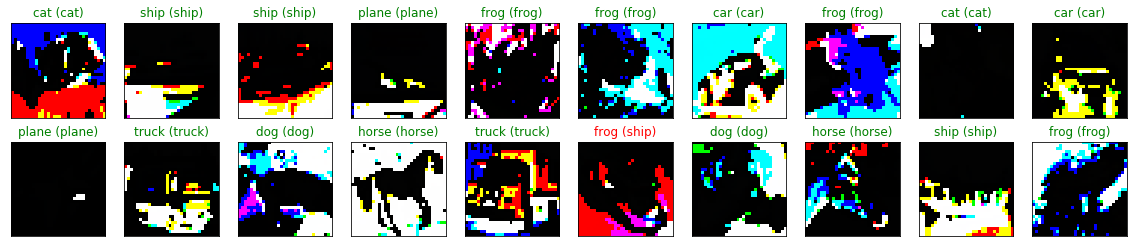

In [20]:
import matplotlib.pyplot as plt
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(np.rollaxis(images[idx], 0, 3)), cmap='gray')
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                 color=("green" if preds[idx]==labels[idx] else "red"))